In [88]:
import pandas as pd
import os
from sklearn.preprocessing import MultiLabelBinarizer
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import torch

In [89]:
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

image_size = 64
batch_size = 1024

# Load the CSV file
df = pd.read_csv("Data/restaurant_photos_filtered.csv")

# split dataset into train, validation and test
train_size = int(0.8 * len(df))
val_size = int(0.1 * len(df))
test_size = len(df) - train_size - val_size

X = df.drop('categories', axis=1)
y = df['categories']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42) 
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42) 

# Encode categories column
mlb = MultiLabelBinarizer()
categories_encoded = mlb.fit_transform(df['categories'].apply(eval))

# Define a custom dataset class
class CustomDataset:
    def __init__(self, dataframe, root_dir, image_size = image_size, transform=None):
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 1]) + ".jpg"  
        image = Image.open(img_name)
        label = categories_encoded[idx] 
        label = label.astype(float) 
        
        if self.transform:
            image = self.transform(image)

        return image, label


class CustomDataset2(Dataset):
    # Your code here
    def __init__(self, dataframe, root_dir, image_size, transform=None):
        """
        Args:
            dataframe (pd.DataFrame): DataFrame containing the file paths and labels.
            root_dir (string): Directory with all the images.
            image_size (tuple): A tuple representing the size (width, height) of the images.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.dataframe = dataframe
        self.root_dir = root_dir
        self.image_size = image_size  # Ensure image_size is passed or defined
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.dataframe.iloc[idx, 1]) + ".jpg"
        image = Image.open(img_name).convert('RGB')  

        label = categories_encoded[idx] 
        label = torch.tensor(label, dtype=torch.float)  

        if self.transform:
            image = self.transform(image)

        return image, label
    

# Define transforms
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])







In [90]:
train_df = pd.concat([X_train, y_train], axis=1)

In [91]:
val_df = pd.concat([X_val, y_val], axis=1)


In [92]:
test_df = pd.concat([X_test, y_test], axis=1)



In [93]:
# Initialize custom dataset
train_dataset = CustomDataset(dataframe=train_df, root_dir="Data/photos", image_size= image_size ,transform=transform)
val_dataset = CustomDataset(dataframe=val_df, root_dir="Data/photos", image_size= image_size ,transform=transform)
test_dataset = CustomDataset(dataframe=test_df, root_dir="Data/photos", image_size= image_size ,transform=transform)

# Initialize data loader
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

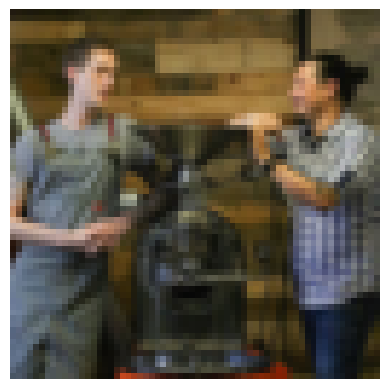

Encoded vector: tensor([0., 1., 1., 1., 1.], dtype=torch.float64)
Decode Labels: [('American (Traditional)', 'Bars', 'Food', 'Nightlife')]
--------------------------------------------------


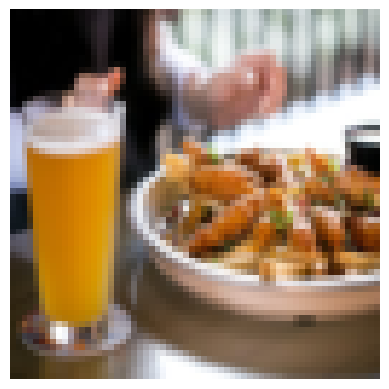

Encoded vector: tensor([0., 0., 0., 1., 0.], dtype=torch.float64)
Decode Labels: [('Food',)]
--------------------------------------------------


In [94]:
import matplotlib.pyplot as plt
import numpy as np


num_samples = 2 
sample_count = 0 

for images, labels in train_loader:
    for i in range(len(images)):
        # Display image
        plt.imshow(np.transpose(images[i], (1, 2, 0)))  
        plt.axis('off')
        plt.show()
        
        # Print encoded vector
        print("Encoded vector:", labels[i])
        
        # Decode labels
        decoded_labels = mlb.inverse_transform(np.expand_dims(labels[i], axis=0))
        print("Decode Labels:", decoded_labels)
        
        print("-" * 50)
        
        sample_count += 1
        if sample_count >= num_samples:
            break
            
    if sample_count >= num_samples:
        break


In [95]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MultiLabelCNN(nn.Module):
    def __init__(self):
        super(MultiLabelCNN, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Second convolutional layer
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        
        # Third convolutional layer
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)

        # Fully connected layers
        self.fc1 = nn.Linear(64 * 8 * 8, 512) 
        self.fc2 = nn.Linear(512, 128)
        
        # Output layer
        self.fc3 = nn.Linear(128, 10) 

    def forward(self, x):
        # Applying convolutions and pooling
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        # Flattening the network
        x = x.view(-1, 64 * 8 * 8)

        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))

        # Output layer
        x = self.fc3(x)
        

        return torch.sigmoid(x)


In [103]:
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MultiLabelCNN().to(device)

# Define loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0008)

epochs = 2 
for epoch in (range(epochs)):
    for inputs, labels in tqdm(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        print(loss)

        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/{epochs}.. Loss: {loss.item():.3f}")

    # Calculate validation loss after epoch 
    val_loss = 0
    accuracy = 0
    with torch.no_grad():
        model.eval()
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            batch_loss = criterion(outputs, labels)
            val_loss += batch_loss.item()
    print(f"Validation loss: {val_loss/len(val_loader):.3f}")
    model.train()

  0%|          | 0/15 [00:00<?, ?it/s]

  7%|▋         | 1/15 [00:04<00:57,  4.08s/it]

tensor(0.7206, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 13%|█▎        | 2/15 [00:07<00:51,  3.94s/it]

tensor(0.7119, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 20%|██        | 3/15 [00:11<00:46,  3.89s/it]

tensor(0.7027, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 27%|██▋       | 4/15 [00:15<00:42,  3.86s/it]

tensor(0.7072, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 33%|███▎      | 5/15 [00:19<00:39,  3.95s/it]

tensor(0.6950, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 40%|████      | 6/15 [00:23<00:35,  3.95s/it]

tensor(0.6865, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 47%|████▋     | 7/15 [00:27<00:31,  3.99s/it]

tensor(0.6684, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 53%|█████▎    | 8/15 [00:31<00:27,  4.00s/it]

tensor(0.6554, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 60%|██████    | 9/15 [00:35<00:24,  4.00s/it]

tensor(0.6505, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 67%|██████▋   | 10/15 [00:39<00:20,  4.06s/it]

tensor(0.6404, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 73%|███████▎  | 11/15 [00:44<00:16,  4.11s/it]

tensor(0.6415, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 80%|████████  | 12/15 [00:48<00:12,  4.14s/it]

tensor(0.6500, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 87%|████████▋ | 13/15 [00:52<00:08,  4.03s/it]

tensor(0.6433, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 93%|█████████▎| 14/15 [00:56<00:04,  4.06s/it]

tensor(0.6492, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 15/15 [00:58<00:00,  3.91s/it]

tensor(0.6572, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Epoch 1/2.. Loss: 0.657


Validation loss: 0.841


  7%|▋         | 1/15 [00:04<00:59,  4.26s/it]

tensor(0.6402, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 13%|█▎        | 2/15 [00:08<00:53,  4.10s/it]

tensor(0.6553, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 20%|██        | 3/15 [00:12<00:47,  3.97s/it]

tensor(0.6463, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 27%|██▋       | 4/15 [00:16<00:43,  4.00s/it]

tensor(0.6269, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 33%|███▎      | 5/15 [00:20<00:39,  3.96s/it]

tensor(0.6424, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 40%|████      | 6/15 [00:24<00:35,  3.99s/it]

tensor(0.6447, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 47%|████▋     | 7/15 [00:28<00:32,  4.02s/it]

tensor(0.6398, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 53%|█████▎    | 8/15 [00:32<00:27,  3.99s/it]

tensor(0.6441, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 60%|██████    | 9/15 [00:36<00:24,  4.00s/it]

tensor(0.6381, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 67%|██████▋   | 10/15 [00:40<00:20,  4.03s/it]

tensor(0.6435, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 73%|███████▎  | 11/15 [00:44<00:15,  3.98s/it]

tensor(0.6441, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 80%|████████  | 12/15 [00:48<00:12,  4.04s/it]

tensor(0.6469, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 87%|████████▋ | 13/15 [00:52<00:08,  4.04s/it]

tensor(0.6455, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


 93%|█████████▎| 14/15 [00:56<00:04,  4.08s/it]

tensor(0.6521, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


100%|██████████| 15/15 [00:59<00:00,  3.94s/it]

tensor(0.6466, device='cuda:0', dtype=torch.float64,
       grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)
Epoch 2/2.. Loss: 0.647


Validation loss: 0.840
